In [3]:
import numpy as np 
import re 
import requests as req 
import matplotlib.pyplot as plt 
import pandas as pd 
from sodapy import Socrata
import geopy as gp
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import collections as col
from imblearn.over_sampling import SMOTENC, SMOTEN, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
#FOUND API. no need for requests
# requ_url = 'https://www.dot.ny.gov/portal/pls/portal/MEXIS_APP.DYN_PROJECT_DETAILS.show'
# req_post = {'p_arg_names': 'p_pin', 'p_arg_values':801079}
# # resp = req.get(requ_url)
# def data_retrieval(url: str, key: list[str]) -> pd.DataFrame:
#     response = req.get(url)
#     if response.ok == True and response.status_code == 200:
#         print('Success')
#     else:
#         print('Failed')
#     data = response.json()
#     return data
# response = req.get(requ_url, params=req_post)
# print(response.text)

In [4]:
client = Socrata("data.ny.gov",app_token='SUV6CnpKWErb1fdYcxWDEXpHl', username='dwightdinkins@gmail.com',password='AVelaryon@2134')
results = client.get("rz8t-4kmq", limit=5000)
results_df = pd.DataFrame.from_records(results)
results_df.columns

Index(['major_pin', 'contract_number', 'region', 'project_title',
       'project_status', 'status', 'bid_opening_date', 'federal_funding',
       'state_funding', 'local_funding', 'type_of_work',
       'public_friendly_description', 'contract_award_date',
       'contract_award_amount', 'approved_cost_changes',
       'current_award_amount', 'estimated_or_actual_completed_date',
       'schedule_performance', 'cost_performance',
       'in_future_development_start_date', 'construction_start_date',
       'construction_end_date', 'construction_amount'],
      dtype='object')

# Data Pre-processing

In [5]:
group_status = results_df.groupby(by='status', as_index=False)
indx = (results_df.status.str.contains('Completed Project', regex=False).to_numpy() == 1).nonzero()

In [6]:
pd.set_option('display.max_columns', 23)
completed = results_df.iloc[indx[0],:].copy()
# Converted COntract Award Date & Estimated Completion Date to Datetime Objects
completed.contract_award_date = pd.to_datetime(completed.contract_award_date)
completed.estimated_or_actual_completed_date = pd.to_datetime(completed.estimated_or_actual_completed_date)

In [7]:
completed_dropped_contruct = completed.drop(columns=['construction_start_date', 'construction_end_date', 'construction_amount']).copy()

In [ ]:
completed_dropped_contruct

In [8]:

def modify_addy(regex: list[str], data: pd.DataFrame, dat_col: pd.Series):
    geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
    geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    hwy_data = dat_col.str.replace(regex[0],r'\1-\2', regex=True).str.extract(regex[1]).dropna()
    loc_data = col.defaultdict(dict)
    for indx, hwy in hwy_data.to_dict()[0].items():
        try:
            location = geolocator(hwy + ', NY', geometry='geojson')
            if location != None:
                loc_data['latitude'][indx] = location.latitude
                loc_data['longitude'][indx] = location.longitude
                # print(loc_data['longitude'][indx])
            else:
                loc_data['latitude'][indx] = np.nan
                loc_data['longitude'][indx] = np.nan
        except OSError:
            pass        

    return loc_data
    
    

In [ ]:
# regex = [r'([NYIRtT\.]+)\s?(\d+)',r'([NYIRtT\.]+-\d+)']
# location_data = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_status)

In [ ]:
# location_data1 = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_title)

In [9]:
location_data = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data1.xlsx")
location_data1 = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data.xlsx")

In [ ]:
location_data

In [10]:
location_data.set_index('Unnamed: 0', inplace=True)
location_data.index.name = ''

location_data1.set_index('Unnamed: 0', inplace=True)
location_data1.index.name = ''

In [ ]:
location_data

In [ ]:
location_data1[location_data1.longitude.isna()].shape

In [ ]:
pd.set_option('display.max_rows', 300)
regex = r'(\d+\s\w+\s[RAdVEveoOaD]+)'
regex1 = r'(\s[\w\s]+and\s[\w\s]+)'
regex2 = r'(?<=between\s)([\w\s]+)and([\w\s]+)'
regex3 = r'(?<=FROM\s)([\w\d\s]+)'
regex4 = r'([NYIRtT\.]+)\s?(\d+)'
regex5 = r'([NYIRtT\.]+-\d+)'
# completed_dropped_contruct.project_status.str.replace(regex4, r'\1-\2', regex=True).str.extract(regex5).dropna()
for i, descrip in location_data[location_data.longitude.isna()].project_status.to_dict().items():
    print(f'{i}: {descrip},')


In [ ]:
location_data[location_data.longitude.isna()]

In [11]:
location_data.loc[1540, ['latitude', 'longitude']] = [42.252865, -73.790962]

In [12]:
rem ={
    0: "Captree State Park",
    32: "Hempstead",
    33: "Commack Rd, Huntington",
    41: "Nassau",
    42: "SUFFOLK",
    43: "NY-25A",
    44: "Nassau",
    46: "SUFFOLK",
    48: "NY-347",
    49: "NY-231",
    51: "Riverhead",
    59: "Nassau",
    62: "Montauk Hwy",
    63: "Old Sunrise Highway",
    64: "William Floyd Pkwy",
    68: "NY-27",
    93: "NY-24",
    254: "New York State",
    279: "ROUTE 29",
    327: "NEW YORK CITY",
    329: "Mohawk Hudson Bike Trail",
    403: "EMPIRE STATE TRAIL",
    442: "NY-418",
    485: "ONEIDA",
    487: "EAST HERKIMER",
    488: "TRENTON & REMSEN",
    490: "HERKIMER",
    491: "NEW HARTFORD",
    497: "New York State",
    503: "New York State",
    580: "Geddes",
    581: "Bronx",
    621: "New York City",
    638: "Manlius",
    644: "ONONDAGA",
    648: "SENECA COUNTY",
    649: "CORTLAND COUNTY",
    652: "TOMPKINS COUNTY",
    668: "TOMPKINS COUNTY",
    671: "I-690",
    672: "CAYUGA",
    676: "OSWEGO",
    759: "MONROE COUNTY",
    769: "Orleans County",
    774: "Empire State Trail",
    775: "MACEDON",
    803: "Edgemere Dr.",
    862: "Livingston County",
    900: "New York State",
    913: "ROUTE 179",
    931: "Amherst",
    934: "Erie County",
    936: "Cattaraugus County",
    939: "Niagara County",
    940: "ERIE COUNTY",
    943: "Niagara County",
    944: "Lewiston",
    949: "Chautauqua",
    951: "Erie County",
    963: "US-62",
    1040: "CATTARAUGUS COUNTY",
    1041: "ERIE COUNTY",
    1042: "NY-426",
    1103: "Empire State Trail",
    1112: "US-20",
    1114: "US-62",
    1120: "US-20",
    1126: "US-20A",
    1128: "NIAGARA FALLS BLVD",
    1130: "New York State",
    1173: "Chemung",
    1177: "SCHUYLER",
    1178: "STEUBEN",
    1179: "I-86",
    1181: "STEUBEN & YATES",
    1229: "YATES",
    1234: "Schuyler & Steuben",
    1289: "New York State",
    1291: "New York State",
    1292: "New York State",
    1293: "New York State",
    1294: "Central New York",
    1296: "Central New York",
    1297: "New York State",
    1332: "New York State",
    1344: "ROUTE 116",
    1346: "ROUTE 100",
    1351: "ROUTE 203",
    1373: "ROUTE 22",
    1383: "ANNSVILLE CIRCLE",
    1387: "ROUTE 202",
    1388: "OAKLEY BOULEVARD",
    1399: "New York State",
    1402: "ROCKLAND & WESTCHESTER COUNTY",
    1403: "New York State",
    1405: "ROCKLAND COUNTY",
    1406: "Putnam & Ulster",
    1409: "ROUTE 213",
    1413: "ORANGE & WESTCHESTER",
    1415: "Dutchess County",
    1416: "PUTNAM County",
    1440: "New York State",
    1450: "Westchester",
    1455: "New York State",
    1462: "New York State",
    1469: "New York State",
    1476: "New York State",
    1484: "Orange & Putnam",
    1487: "Rockland",
    1489: "Ulster",
    1520: "SAW MILL RIVER PARKWAY",
    1522: "PUTNAM & WESTCHESTER",
    1528: "GREENBURGH",
    1529: "HAVERSTRAW",
    1536: "Route 44",
    1538: "ROUTE 17K",
    1539: "HUNGRY HOLLOW ROAD",
    1540: "NEW PALTZ & LLYOD",
    1635: "ROUTE 59",
    1637: "TACONIC PARKWAY",
    1639: "EMPIRE STATE TRAIL, KINGSTON",
    1640: "ALBANY HUDSON ELECTRIC TRAIL",
    1654: "Bethel",
    1673: "Owego",
    1717: "Chenango",
    1719: "US-11",
    1761: "Wyoming",
    1787: "Route 97",
    1866: "I-278",
    1882: "Van Wyck Expressway",
    1887: "New York City",
    1894: "New York State",
    1895: "New York City",
    1896: "New York City",
    1897: "New York City",
    1898: "New York city",
    1900: "Bronx",
    1903: "New York City",
    1904: "NYC",
    1905: "NYC",
    1908: "West 57th St."
}


In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
location = geolocator.geocode('West 57th St., NY', geometry='geojson', exactly_one=True)
location.latitude, location.longitude

In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
loc_data = col.defaultdict(dict)
for indx, hwy in rem.items():
    try:
        location = geolocator(hwy + ', NY', geometry='geojson')
        if location != None:
            loc_data['latitude'][indx] = location.latitude
            loc_data['longitude'][indx] = location.longitude
            # print(loc_data['longitude'][indx])
        else:
            loc_data['latitude'][indx] = np.nan
            loc_data['longitude'][indx] = np.nan
    except OSError:
        pass

In [ ]:
# location_data[['latitude', 'longitude']] = location_data[['latitude', 'longitude']].combine_first(pd.DataFrame(loc_data))

In [ ]:
# (location_data[['latitude', 'longitude']].isna() == True).to_numpy().nonzero()

In [13]:
tow = location_data.type_of_work.str.replace('/',' ').str.replace(':', '').str.replace('(','').str.replace(')','').str.replace(',','')
tow


0                    Bicycle Facility Highway New
17                         Pavement Mill and Fill
20      Pedestrian Facility Highway Improve Rehab
21        Pavement Concrete Pavement Repair Heavy
29         Guiderail Median Barrier Rehab Improve
                          ...                    
1900    Pedestrian Facility Highway Improve Rehab
1903             Retaining Wall New Improve Rehab
1904             Emergency Response Bridge Repair
1905             Emergency Response Bridge Repair
1908      Pavement Concrete Pavement Repair Heavy
Name: type_of_work, Length: 291, dtype: object

In [14]:
words = tow.str.split().to_numpy()
unique_set = list()
for word in words:
  print(word)
  unique_set.extend(word)
num_of_appearance = dict()
for item in set(unique_set):
  num_of_appearance[item] = unique_set.count(item)

['Bicycle', 'Facility', 'Highway', 'New']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'Improve', 'Rehab']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Pavement', 'Mill', 'and', 'Fill']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Bridge', 'Replacement', 'Functional']
['Traffic', 'Signals', 'Devices', 'Coordination']
['Bridge', 'Maintenance', 'Cyclical', 'Washing', 'Sealing', 'Cleaning', 'etc.']
['Pavement', 'Mill', 'and', 'Fill']
['Other']
['Emergency', 'Response', 'Highway']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Bridge', 'Deck', 'Replacement']
['Pavement', 'Marking']
['Pavement', 'Crack', 'or', 'Joint', 'Sealing']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'New']
['Bridge', 'Vertical', 'Down', 'Rehab']
['Pavement', 'Sing

In [ ]:
num_of_appearance

In [15]:
pattern = re.compile(r'(Bridge|Pavement|Highway|Traffic|Guiderail|Culvert|Drainage|Vegetation)')
categories = tow.str.extract(pattern)
categories

,0
,
0,Highway
17,Pavement
20,Highway
21,Pavement
29,Guiderail
...,...
1900,Highway
1903,NaN
1904,Bridge


In [16]:
location_data.type_of_work[categories[0].isna()] = 'Other'
location_data.type_of_work[categories[0].notna()] = categories[0]

C:\Users\dwigh\AppData\Local\Temp\ipykernel_3076\634246089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].isna()] = 'Other'
C:\Users\dwigh\AppData\Local\Temp\ipykernel_3076\634246089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].notna()] = categories[0]


In [ ]:
# pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 23)
location_data.head(5)

In [20]:
x_columns = ['major_pin', 'contract_number', 'region', 'status', 'bid_opening_date', 'federal_funding',
       'state_funding', 'local_funding', 'type_of_work',
        'contract_award_date',
       'contract_award_amount', 'approved_cost_changes',
       'current_award_amount',
       'schedule_performance', 'cost_performance',
        'latitude', 'longitude']
y_column = 'current_award_amount'

In [ ]:
# smote = SMOTEN(sampling_strategy='minority', random_state=0)
# X, Y = smote.fit_resample(location_data.loc[:,x_columns], location_data.loc[:,y_column])
# location_data.type_of_work.value_counts()
(location_data[location_data.contract_number.isna()]).index

In [27]:
dropped_contract_numbers = location_data.drop(index = (location_data[location_data.contract_number.isna()]).index)

In [28]:
dropped_contract_numbers = dropped_contract_numbers.drop(columns=['public_friendly_description', 'project_title', 'project_status', 'major_pin', 'contract_number', 'bid_opening_date',
                                                                 'current_award_amount', 'schedule_performance', 'cost_performance',
                                                                'in_future_development_start_date'])

In [ ]:
dropped_contract_numbers

In [20]:
new_x_columns = dropped_contract_numbers.columns

In [29]:
dropped_contract_numbers.federal_funding = dropped_contract_numbers.federal_funding.astype('category')
dropped_contract_numbers.state_funding = dropped_contract_numbers.state_funding.astype('category')
dropped_contract_numbers.local_funding = dropped_contract_numbers.local_funding.astype('category')
dropped_contract_numbers.region = dropped_contract_numbers.region.astype('category')

In [30]:
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Vegetation', 'Other')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Culvert','Drainage')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Guiderail','Traffic')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Pavement','Highway')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Bridge','Highway')


In [20]:
dropped_contract_numbers.head()

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
,,,,,,,,,,,,,,,,,,,,,,
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Highway,Project proposes to construct the 3rd phase of...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Highway,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Highway,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,Highway,This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Traffic,This project proposes to replace existing the ...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219


<Figure size 1920x1440 with 0 Axes>

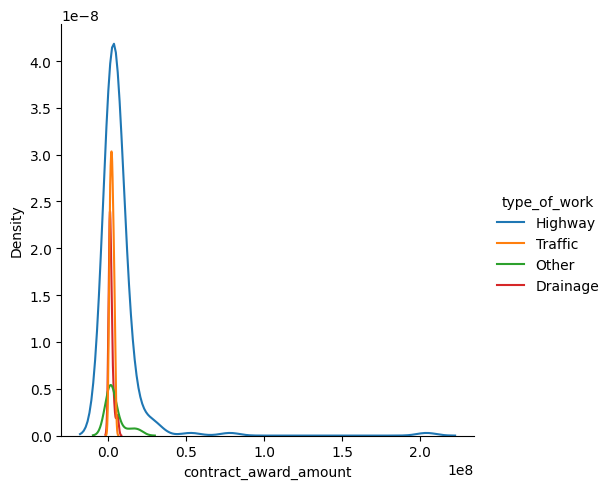

In [21]:
import seaborn as sns
plt.figure(dpi=300)
sns.displot(dropped_contract_numbers, x='contract_award_amount', hue='type_of_work', kind='kde')

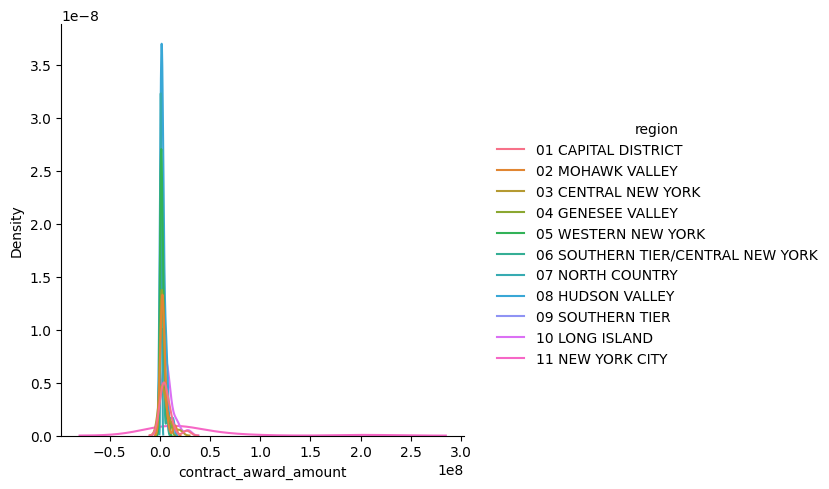

In [22]:
sns.displot(dropped_contract_numbers, x='contract_award_amount', hue='region', kind='kde')

In [258]:
cleaned_data = dropped_contract_numbers.drop(columns=['status','contract_award_amount', 'approved_cost_changes','estimated_or_actual_completed_date'])

In [259]:
categories = [
	cleaned_data['region'].unique().tolist(),
	cleaned_data['federal_funding'].unique().tolist(),
	cleaned_data['state_funding'].unique().tolist(),
	cleaned_data['local_funding'].unique().tolist(),
	cleaned_data['type_of_work'].unique().tolist()
]

ordinal = OrdinalEncoder(categories=categories)
ordinal.fit(cleaned_data[['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']])

OrdinalEncoder(categories=[['10 LONG ISLAND', '01 CAPITAL DISTRICT',
                            '11 NEW YORK CITY', '02 MOHAWK VALLEY',
                            '03 CENTRAL NEW YORK', '04 GENESEE VALLEY',
                            '05 WESTERN NEW YORK',
                            '06 SOUTHERN TIER/CENTRAL NEW YORK',
                            '07 NORTH COUNTRY', '08 HUDSON VALLEY',
                            '09 SOUTHERN TIER'],
                           ['Yes', 'No'], ['Yes', 'No'], ['No', 'Yes'],
                           ['Highway', 'Traffic', 'Other', 'Drainage']])

In [142]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232 entries, 0 to 1908
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   region               232 non-null    category      
 1   federal_funding      232 non-null    category      
 2   state_funding        232 non-null    category      
 3   local_funding        232 non-null    category      
 4   type_of_work         232 non-null    object        
 5   contract_award_date  232 non-null    datetime64[ns]
 6   latitude             232 non-null    float64       
 7   longitude            232 non-null    float64       
dtypes: category(4), datetime64[ns](1), float64(2), object(1)
memory usage: 10.7+ KB


In [260]:
cleaned_data.sort_values(by='contract_award_date', inplace=True)

In [261]:
current_award_amount = location_data.loc[cleaned_data.index, 'current_award_amount']

<Axes: ylabel='Density'>

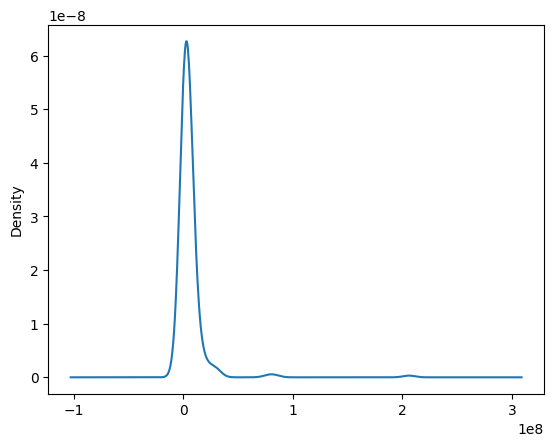

In [262]:
current_award_amount.plot(kind='kde')

In [263]:
norm_caa = current_award_amount.apply(lambda x: (x- current_award_amount.min())/(current_award_amount.max()-current_award_amount.min()))


In [249]:
# Only for Standardization
# norm_caa = norm_caa.drop(index = norm_caa[norm_caa > 4].index)


In [264]:
norm_caa


1865    0.404171
1894    0.108566
301     0.003004
254     0.010415
1289    0.004994
          ...   
1710    0.019113
884     0.041273
1344    0.001237
1294    0.003927
803     0.002588
Name: current_award_amount, Length: 232, dtype: float64

In [265]:
cleaned_data = cleaned_data.loc[norm_caa.index]

In [266]:
columns_to_transform = ['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']
transformed_data = pd.DataFrame(np.hstack((ordinal.transform(cleaned_data[columns_to_transform]), cleaned_data[['latitude', 'longitude']].to_numpy())), columns=columns_to_transform + ['latitude', 'longitude'], index=cleaned_data.index)

X_train, X_test, y_train, y_test = train_test_split(transformed_data,norm_caa, test_size=0.3, random_state=0)

In [292]:
RF = RandomForestRegressor(n_estimators=100, random_state=0)
RF.fit(X_train, y_train)
print(f'Training Score: {np.square(y_train - RF.predict(X_train)).mean()}')
print(f'Testing Score: {np.square(y_test - RF.predict(X_test)).mean()}')   

Training Score: 0.0010850873101745143
Testing Score: 0.0033918917589192904


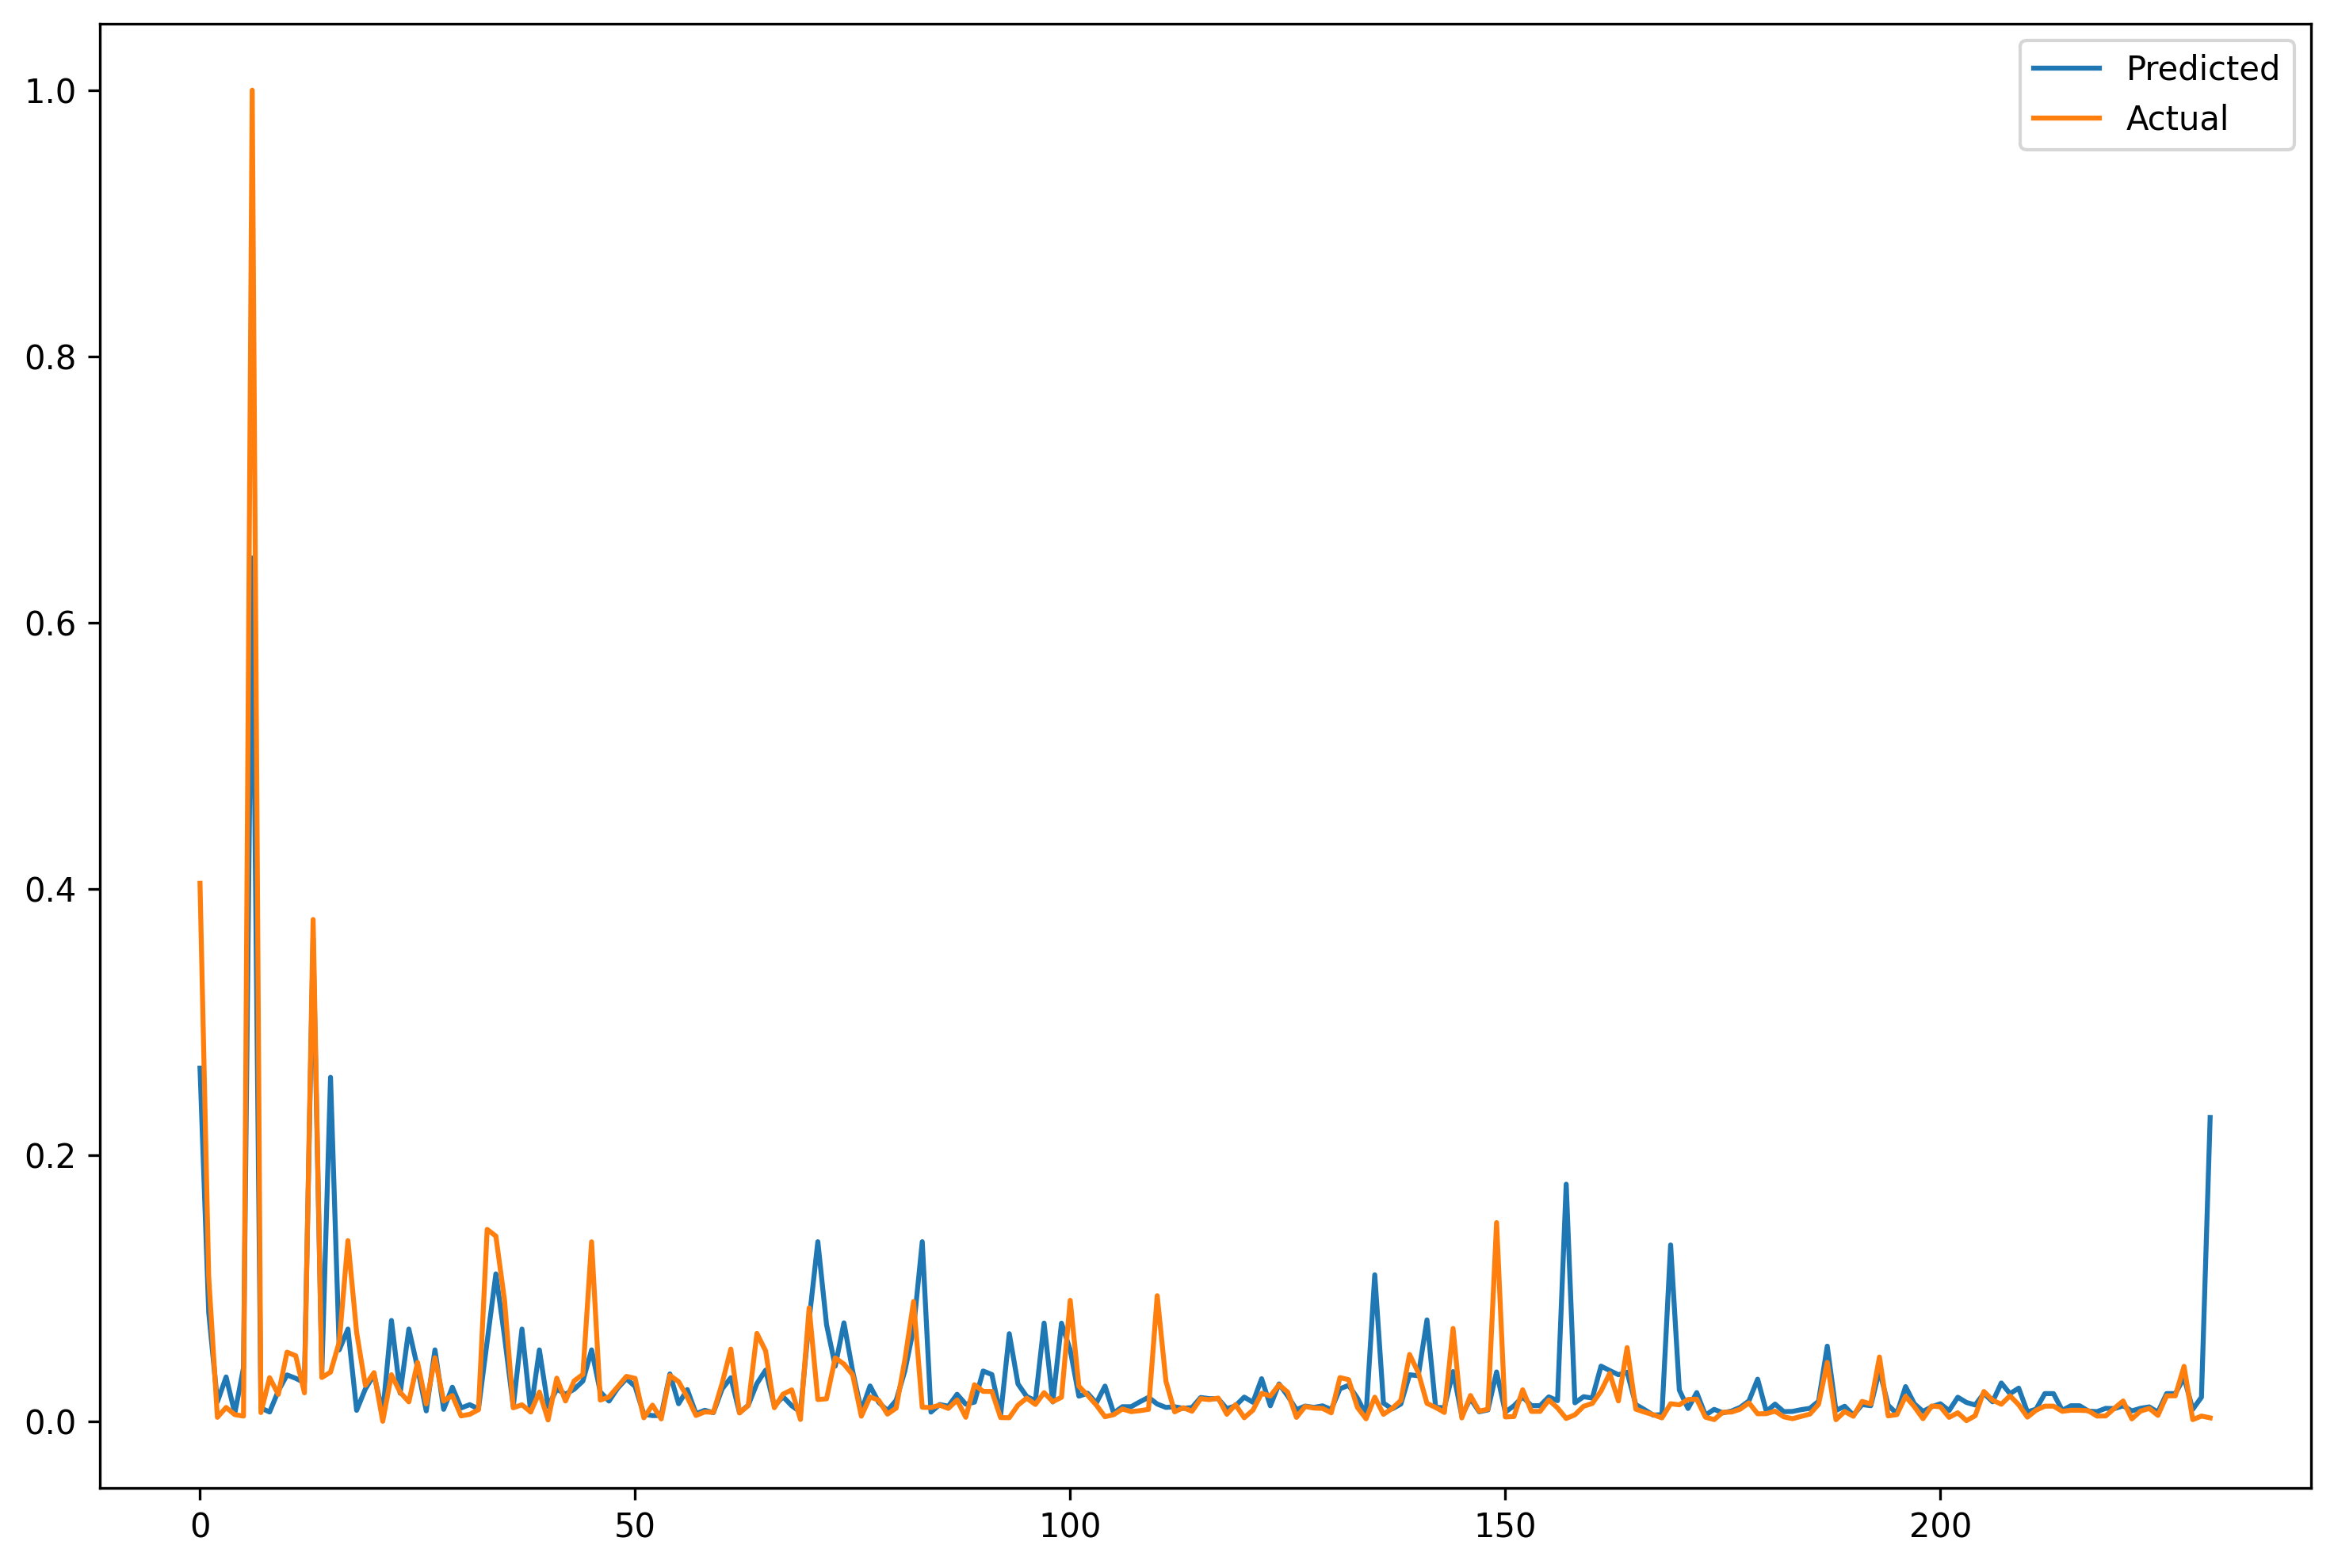

In [293]:
fig, ax = plt.subplots(1,1, figsize=(12,8), dpi=300)
ax.plot(range(transformed_data.shape[0]), RF.predict(transformed_data), label='Predicted')
ax.plot(range(transformed_data.shape[0]), norm_caa, label='Actual')
ax.legend()
plt.show()

In [294]:
def pvit(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true)
    ST = dict()
    for col in data.columns:
        d = data.copy()
        perm_feat = np.roll(data[col].to_numpy(), rows//2, axis=0)
        d[col] = perm_feat
        y_pred = f(d)
        ST[col] = np.square(y_true - y_pred).mean()/(2*Vy)
    return ST

In [295]:
pvit(X_train, y_train, RF.predict)
sum(pvit(X_train, y_train, RF.predict).values())

np.float64(1.0925739823113783)

In [296]:
pvit(X_train, y_train, RF.predict)

{'region': np.float64(0.14251159339023603),
 'federal_funding': np.float64(0.069719506168053),
 'state_funding': np.float64(0.06766388394433905),
 'local_funding': np.float64(0.1779857125282907),
 'type_of_work': np.float64(0.07149899526935728),
 'latitude': np.float64(0.42164115107172684),
 'longitude': np.float64(0.14155313993937535)}

In [315]:
# Hence the model is linear
RF.feature_importances_

array([0.11735728, 0.00911271, 0.00127365, 0.1806605 , 0.01732564,
       0.41256346, 0.26170675])

In [305]:
def pvi(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true)
    SI = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(), rows//2, axis=0), columns=data.columns)
    for col in data.columns:
        r = rolled_data.copy()
        r[col] = data[col]
        y_pred = f(r)
        SI[col] = 1 - np.square(y_true - y_pred).mean()/(2*Vy)
    return SI

In [312]:
import itertools as it
def pvi2(data: pd.DataFrame,y_true: pd.Series, f: callable, SI: dict):
    rows, columns = data.shape
    Vy = np.var(y_true)
    SIK = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(), rows//2, axis=0), columns=data.columns)
    for col1, col2 in it.combinations(data.columns,r=2):
        r = rolled_data.copy()
        r[[col1, col2]] = data[[col1, col2]]
        y_pred = f(r)
        SIK[(col1,col2)] = 1 - np.square(y_true - y_pred).mean()/(2*Vy) - SI[col1] - SI[col2]
    return SIK

In [313]:
SI = pvi(X_train, y_train, RF.predict)

In [297]:
np.var(y_train)

np.float64(0.008042271169495373)

In [225]:
# dropped_contract_numbers = pd.get_dummies(dropped_contract_numbers, columns=['federal_funding', 'state_funding', 'local_funding', 'type_of_work'],dtype='int', drop_first=True)

In [226]:
# dropped_contract_numbers.drop(columns=['estimated_or_actual_completed_date', 'major_pin', 'contract_number','status','bid_opening_date','estimated_or_actual_completed_date'], inplace=True)

In [227]:
# ideasss = dropped_contract_numbers.drop(columns=['approved_cost_changes','schedule_performance','cost_performance'])

In [ ]:
dropped_contract_numbers

In [170]:
# from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
# X_DCN = dropped_contract_numbers.loc[:,new_x_columns]
# Y = dropped_contract_numbers.loc[:,y_column]
# nun = len(X_DCN.type_of_work.unique())
# discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
# Y_binned = discret.fit_transform(Y.to_numpy().reshape((-1,1))).ravel()

# smote = SMOTEN(sampling_strategy='minority',random_state=0)
# X, Y = smote.fit_resample(X_DCN, Y_binned)